# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, SVM Grid Search

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [3]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ZlxZ3i0RP9I" frameborder="0" 
allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [2]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.metrics import classification_report

# Random Seed
from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

## Auxiliary Functions

In [3]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [4]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


## Load Labels

In [5]:
filename="instruments_labels.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    classes_num = pickle.load( open( filename, "rb" ) )

## Parameters for MFCC

In [6]:
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

## Save / Load Feature Vector

In [7]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

## Train and Test Sets

In [8]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [9]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


## SVM Classification with Grid Search

In [10]:
show_web("https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html")

In [11]:
# SVM Grid Search
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
grid_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=5)


In [12]:
print (param_grid)

{'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])}


In [13]:
# SVM
grid_svm.fit(train_set, train_classes)
print("The best parameters are %s with a score of %0.2f"
      % (grid_svm.best_params_, grid_svm.best_score_))



The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.98


### Save / Load Trained Model

In [14]:
# Save
joblib.dump(grid_svm, 'trained_grid_SVM.joblib')
#Load
#svclassifier = joblib.load('trained_grid_SVM.joblib') 

['trained_grid_SVM.joblib']

In [15]:
# Predict using the Test Set
predicted_labels = grid_svm.predict(test_set)

## Evaluation

In [16]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

print(classification_report(test_classes, predicted_labels))

Recall:  [1.   1.   0.96 1.   1.   1.  ]
Precision:  [1.         1.         1.         1.         0.96153846 1.        ]
F1-Score:  [1.         1.         0.97959184 1.         0.98039216 1.        ]
Accuracy: 0.99  , 149
Number of samples: 150
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      0.96      0.98        25
           3       1.00      1.00      1.00        25
           4       0.96      1.00      0.98        25
           5       1.00      1.00      1.00        25

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [17]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [18]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

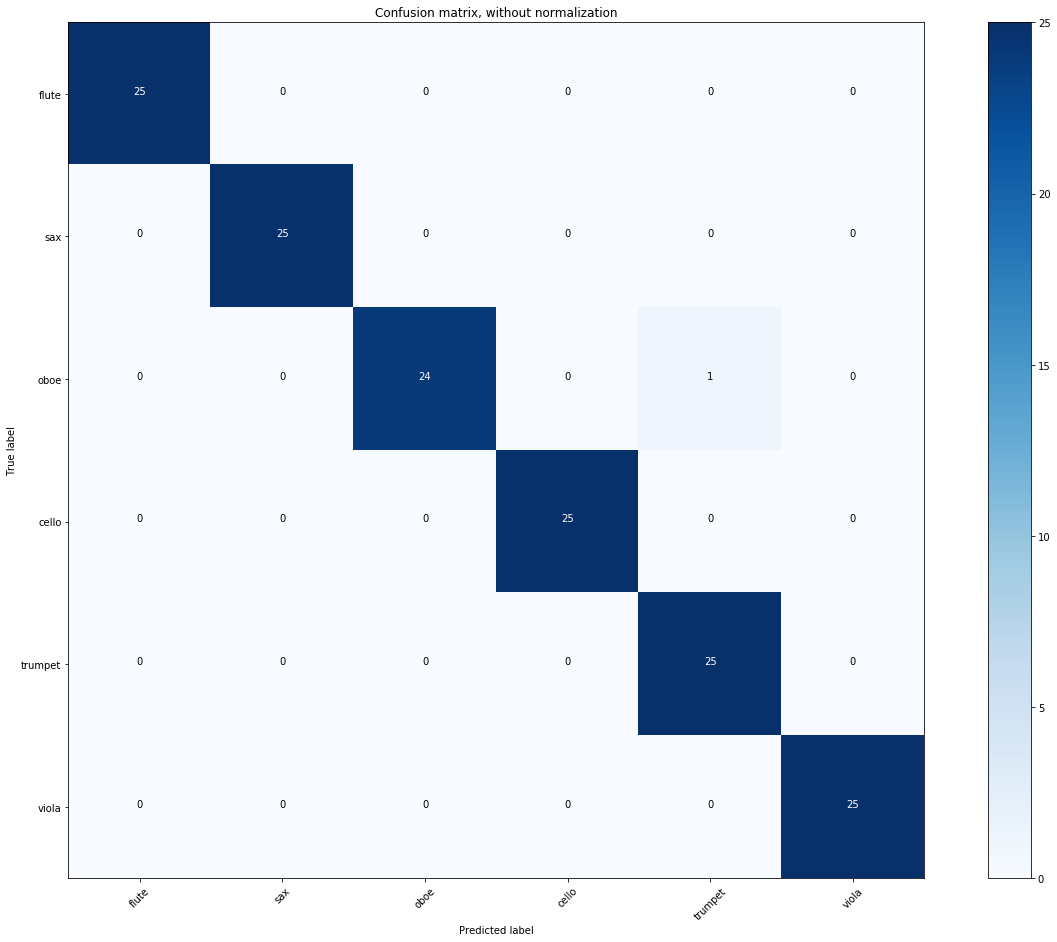

In [19]:
# Plot non-normalized confusion matrix
classes=['flute','sax','oboe', 'cello','trumpet','viola']
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')